In [413]:
# autoreload to reload modules when they change
%load_ext autoreload
%autoreload 2

import rollout
from torch import optim
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn

from tqdm import trange

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from rollout.dataset import generate_combinations
import math 
from torch.utils.data import Dataset

class InductionValueDataset(Dataset):
    def __init__(self, num_tokens, sequence_length, random_seed=42):
        assert sequence_length <= num_tokens, "sequence_length must be less than or equal to num_tokens"

        torch.manual_seed(random_seed)
        self.num_tokens = num_tokens
        self.sequence_length = sequence_length

        
        X, y = generate_combinations(num_tokens, sequence_length, 1, return_output=True)
        self.n_samples = X.shape[0]

        self.data = X

        self.task_tokens = dict(induction=num_tokens,
                                value=num_tokens+1)
        self.labels = dict(induction=y,
                           value=torch.max(X, dim=1).values)
        # set the second half of the data to be the value task
        del X, y 

        shuffle_idx = torch.randperm(self.n_samples)

        self.n_train = int(self.n_samples * 0.8)
        self.train_idx = torch.arange(self.n_train)

        self.test_idx = torch.arange(self.n_train, self.n_samples)
        self.n_test = len(self.test_idx)
    
    def __len__(self):
        return self.n_samples
    
    def __getitem__(self, idx, task=None):
        assert task in [None, "value", "induction"], "task must be None, value, or induction. If None, a task will be randomly selected."
        if task is None:
            task = np.random.choice(["value", "induction"])
        if type(idx == int):
            n_items = 1
        else:
            n_items = len(idx)
        sample = torch.zeros(n_items, self.sequence_length + 1)
        sample[:, 1:] = self.data[idx]
        sample[:, 0] = self.task_tokens[task]
        label = self.labels[task][idx]
        
        return sample, label
    
    def generate_batch(self, batch_size, type='train', task=None):
        """
        Generates a batch of data for training or testing.
        Args:
            batch_size (int): Number of samples in the batch.
            type (str, optional): Type of data to generate ('train' or 'test'). Defaults to 'train'.
        Returns:
            tuple: A tuple containing the input sequences (X) and the output sequences (y).
        """
        #TODO: implment interleaved tasks in training
        assert task in [None, "value", "induction"], "task must be None, value, or induction. If None, a task will be randomly selected."
        
        if task is None:
            task = np.random.choice(["value", "induction"])

        assert type in ['train', 'test'], "type must be either 'train' or 'test'"
        if type == 'train':
            idx = self.train_idx[torch.randint(0, self.n_train, (batch_size,))]
        else:
            idx = self.test_idx[torch.randint(0, self.n_test, (batch_size,))]
        task_column = torch.ones(batch_size, 1, dtype=torch.long)*self.task_tokens[task]
        X = torch.cat((task_column, self.data[idx]), dim=1)
        y = self.labels[task][idx]
        return X, y
    
n_tokens = 10
sequence_length = 6
dset = InductionValueDataset(n_tokens, sequence_length)

In [410]:
def optimize_dual_model(model, criterion, optimizer, dataset, n_epochs=1000, batch_size=32):
    """
    Trains and evaluates the given model using the specified criterion and optimizer.
    Args:
        model (torch.nn.Module): The model to be trained and evaluated.
        criterion (torch.nn.Module): The loss function used to evaluate the model.
        optimizer (torch.optim.Optimizer): The optimizer used to update the model parameters.
        dataset (Dataset): The dataset object that provides training and testing data.
        n_epochs (int, optional): The number of epochs to train the model. Default is 1000.
        batch_size (int, optional): The number of samples per batch. Default is 32.
    Returns:
        tuple: A tuple containing two lists:
            - train_losses (list of float): The training loss recorded at each epoch.
            - test_losses (list of float): The testing loss recorded at each epoch.
    """
    train_losses = []
    test_losses = []
    train_task = []
    test_task = []
    for epoch in trange(n_epochs):
        model.train()
        X, y = dataset.generate_batch(batch_size, type='train')
        task = X[0, 0]
        optimizer.zero_grad()
        y_pred = model(X)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        train_task.append(task)
        train_losses.append(loss.item())

        model.eval()
        X, y = dataset.generate_batch(batch_size, type='test')
        task = X[0, 0]
        y_pred = model(X)
        loss = criterion(y_pred, y)
        test_losses.append(loss.item())
        test_task.append(task)

        #if epoch % 100 == 0:
        #    print(f"Epoch {epoch}: Train Loss ({train_task[-1]}): {train_losses[-1]}, Test Loss ({test_task[-1]}): {test_losses[-1]}")
    return np.array(train_losses), np.array(test_losses), np.array(train_task), np.array(test_task)

In [369]:

torch.manual_seed(0)
d_model = 64
n_tokens = 10
max_positions = 6


dataset = InductionValueDataset(n_tokens, max_positions)

transformer2x1 = rollout.models.FlexibleTransformer(d_model, n_tokens+2, max_positions+1, 1, 2)
optimizer = optim.AdamW(transformer2x1.parameters(), lr=0.002)
criterion = nn.functional.cross_entropy

complex_train_losses, complex_test_losses, complex_train_task, complex_test_task =optimize_dual_model(transformer2x1, criterion, optimizer, dataset, n_epochs=2000, batch_size=1024)


Epoch 0: Train Loss (11): 2.511103868484497, Test Loss (11): 1.6621476411819458
Epoch 100: Train Loss (10): 1.787685751914978, Test Loss (10): 2.128457546234131


KeyboardInterrupt: 

In [411]:
import pickle 
import os
def run_dual_task_experiment(d_model, n_tokens, max_positions, n_heads, n_layers, n_epochs=1000, batch_size=1024,
                               random_seed=42, lr=0.002, save=False, fname=None):
    torch.manual_seed(random_seed)
    np.random.seed(random_seed)
    model = rollout.models.FlexibleTransformer(d_model, n_tokens+2, max_positions+1, n_heads, n_layers)
    optimizer = optim.AdamW(model.parameters(), lr=0.002)
    criterion = nn.functional.cross_entropy
    train_losses, test_losses, train_task, test_task =optimize_dual_model(model, criterion, optimizer, dataset,
                                                                           n_epochs=n_epochs, batch_size=batch_size)
    res = dict(train_losses=train_losses, test_losses=test_losses, train_task=train_task, test_task=test_task)
    if save:
        os.makedirs(fname, exist_ok=True)
        torch.save(model, fname + "/model.pt")
        with open(fname + "/results.pkl", "wb") as f:
            pickle.dump(res, f)
        print("model saved to ", fname)
    return res

In [390]:
n_heads = 1
n_layers = 2
n_tokens = 10
max_positions = 6
d_model = 64
random_seed = 0
fname = os.getcwd() + f"/data/dual_task/Attention_Only_{n_layers}Lx{n_heads}H_{d_model}D_{n_tokens}T_{max_positions}P_RS{random_seed}"

run_dual_task_experiment(d_model, n_tokens, max_positions, n_heads, n_layers, n_epochs=10000, batch_size=1024, 
                         random_seed=random_seed, save=True, fname=fname)



Epoch 0: Train Loss (11): 2.500769853591919, Test Loss (10): 2.8566513061523438
Epoch 100: Train Loss (10): 1.2670135498046875, Test Loss (11): 0.026245975866913795
Epoch 200: Train Loss (11): 0.03409401699900627, Test Loss (10): 0.4315956234931946
Epoch 300: Train Loss (11): 0.015094694681465626, Test Loss (11): 0.050623029470443726
Epoch 400: Train Loss (10): 0.0026893955655395985, Test Loss (11): 0.0011046091094613075
Epoch 500: Train Loss (10): 0.0012739085359498858, Test Loss (11): 0.009367949329316616
Epoch 600: Train Loss (11): 0.00024198999744839966, Test Loss (11): 0.006832041312009096
Epoch 700: Train Loss (10): 0.00039261661004275084, Test Loss (10): 0.0020693433471024036
Epoch 800: Train Loss (11): 0.00021612759155686945, Test Loss (10): 0.0014023405965417624
Epoch 900: Train Loss (11): 0.0001295992115046829, Test Loss (10): 0.0015409818151965737
Epoch 1000: Train Loss (10): 0.0002348370326217264, Test Loss (10): 0.0010455441661179066
Epoch 1100: Train Loss (10): 0.00023217

{'train_losses': array([2.50076985e+00, 2.75767231e+00, 2.72361088e+00, ...,
        1.75320920e-07, 9.84871235e-07, 1.59487939e-07]),
 'test_losses': array([2.85665131e+00, 1.54636145e+00, 2.73970723e+00, ...,
        5.35544605e-05, 1.06153141e-06, 3.67243374e-05]),
 'train_task': array([11, 10, 10, ..., 11, 10, 11]),
 'test_task': array([10, 11, 10, ..., 10, 11, 11])}

In [454]:
n_heads = 1
n_layers = 2
n_tokens = 10
max_positions = 6
d_model = 64
random_seed = 0

for random_seed in [20, 200, 2000, 20000]:
    print("random_seed: ", random_seed)
    fname = os.getcwd() + f"/data/dual_task/Attention_Only_{n_layers}Lx{n_heads}H_{d_model}D_{n_tokens}T_{max_positions}P_RS{random_seed}"

    run_dual_task_experiment(d_model, n_tokens, max_positions, n_heads, n_layers, n_epochs=10000, batch_size=1024, 
                            random_seed=random_seed, save=True, fname=fname)


random_seed:  50


100%|██████████| 10000/10000 [07:56<00:00, 20.97it/s]


model saved to  /Users/ehu7/Projects/TransformerCircuits/data/dual_task/Attention_Only_2Lx1H_64D_10T_6P_RS50
random_seed:  500


100%|██████████| 10000/10000 [08:01<00:00, 20.75it/s]


model saved to  /Users/ehu7/Projects/TransformerCircuits/data/dual_task/Attention_Only_2Lx1H_64D_10T_6P_RS500
random_seed:  5000


100%|██████████| 10000/10000 [07:57<00:00, 20.95it/s]


model saved to  /Users/ehu7/Projects/TransformerCircuits/data/dual_task/Attention_Only_2Lx1H_64D_10T_6P_RS5000
random_seed:  50000


100%|██████████| 10000/10000 [07:55<00:00, 21.02it/s]


model saved to  /Users/ehu7/Projects/TransformerCircuits/data/dual_task/Attention_Only_2Lx1H_64D_10T_6P_RS50000


In [415]:
transformer2x1 = torch.load(fname + "/model.pt")

/var/folders/23/ryhrv04s5_q_zzrtln1zy1gc0000gn/T/ipykernel_21786/2254965406.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  transformer2x1 = torch.load(fname + "/model.p

In [323]:
d_model = 64
transformer1x1 = rollout.models.FlexibleTransformer(d_model, n_tokens+2, max_positions+1, 1, 1)
optimizer = optim.AdamW(transformer1x1.parameters(), lr=0.002)
criterion = nn.functional.cross_entropy

simple_train_losses, simple_test_losses, simple_train_task, simple_test_task =optimize_dual_model(transformer1x1, criterion, optimizer, dataset, n_epochs=1000, batch_size=1024)

Epoch 0: Train Loss (10): 2.8885347843170166, Test Loss (11): 2.474562168121338
Epoch 100: Train Loss (10): 2.079826831817627, Test Loss (11): 0.14069442451000214
Epoch 200: Train Loss (10): 2.068575382232666, Test Loss (10): 2.28774356842041
Epoch 300: Train Loss (11): 0.02445012517273426, Test Loss (10): 2.300527811050415
Epoch 400: Train Loss (10): 1.9226609468460083, Test Loss (10): 2.178765058517456
Epoch 500: Train Loss (10): 1.935835599899292, Test Loss (11): 0.10022813081741333
Epoch 600: Train Loss (10): 1.8536162376403809, Test Loss (11): 0.04885642230510712
Epoch 700: Train Loss (10): 1.9124703407287598, Test Loss (10): 2.120332956314087
Epoch 800: Train Loss (11): 0.012121409177780151, Test Loss (11): 0.07058534026145935
Epoch 900: Train Loss (10): 1.8560055494308472, Test Loss (11): 0.11673357337713242
Epoch 1000: Train Loss (10): 2.184159517288208, Test Loss (10): 2.2033283710479736
Epoch 1100: Train Loss (10): 1.7537301778793335, Test Loss (10): 1.9326963424682617
Epoch 

In [416]:
def split_task_losses(task_losses, task_labels):
    task_losses = np.array(task_losses)
    task_labels = np.array(task_labels)
    task1_losses = task_losses[task_labels == 10]
    task2_losses = task_losses[task_labels == 11]
    task1_idx = np.where(task_labels == 10)[0]
    task2_idx = np.where(task_labels == 11)[0]

    return dict(induction_loss=task1_losses, value_loss=task2_losses,
                 induction_idx=task1_idx, value_idx=task2_idx)


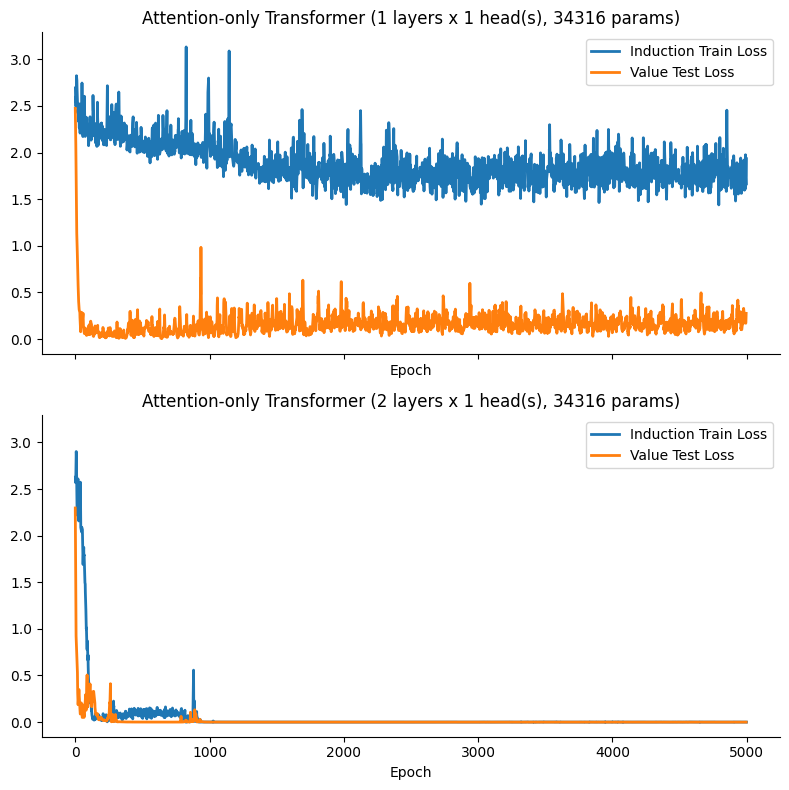

In [394]:
fig, ax = plt.subplots(2, 1, figsize=(8, 8), tight_layout=True, sharex=True, sharey=True)
def plot_losses_by_task(ax, task_losses, task_labels, title):
    res = split_task_losses(task_losses, task_labels)
    ax.plot(res["induction_idx"], res["induction_loss"], label='Induction Train Loss', linewidth=2)
    ax.plot(res["value_idx"], res["value_loss"], label='Value Test Loss', linewidth=2)
    ax.set_xlabel("Epoch")
    #x = np.arange(0, 3500, 500)
    #ax.set_xticks(x, x*50)
    #ax.set_xlim(-50, 2500)
    ax.legend()
    ax.set_title(title)

    import seaborn as sns
    sns.despine()

num_simple_params = sum(p.numel() for p in transformer2x1.parameters() if p.requires_grad)
plot_losses_by_task(ax[0], simple_test_losses, simple_test_task, f"Attention-only Transformer (1 layers x 1 head(s), {num_simple_params} params)")
num_complex_params = sum(p.numel() for p in transformer2x1.parameters() if p.requires_grad)
plot_losses_by_task(ax[1], complex_test_losses, complex_test_task, f"Attention-only Transformer (2 layers x 1 head(s), {num_complex_params} params)")

In [395]:
value_sample = dataset.generate_batch(100, type='train', task='value')

In [398]:
samp =  0

In [450]:
transformer2x1 = torch.load(os.getcwd() + "/data/dual_task/Attention_Only_2Lx1H_64D_10T_6P_RS1000/model.pt")

/var/folders/23/ryhrv04s5_q_zzrtln1zy1gc0000gn/T/ipykernel_21786/2258075310.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  transformer2x1 = torch.load(os.getcwd() + "/d

tensor(7) tensor(6)


Text(0.5, 1.0, 'Induction Task Attention Weights')

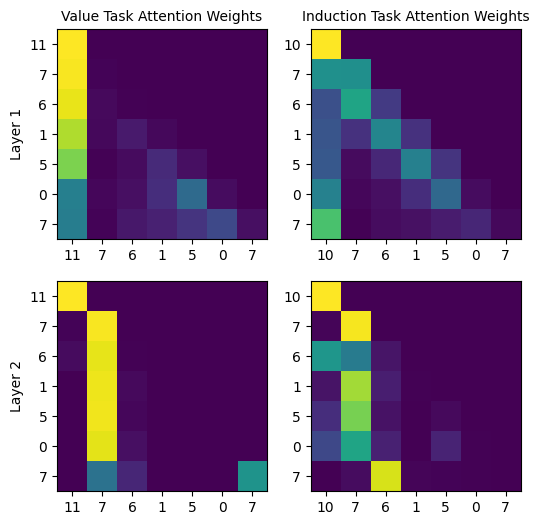

In [453]:
samp+=1 
X = value_sample[0][samp, :].unsqueeze(0)

X_induction = X.clone()
X_induction[0][0] = X_induction[0][0] - 1
value_logits, value_attn_weights = transformer2x1.forward_with_weights(X)
induction_logits, induction_attn_weights = transformer2x1.forward_with_weights(X_induction)
print(torch.argmax(value_logits), torch.argmax(induction_logits))
fig, ax = plt.subplots(2, 2, figsize=(6, 6))
axis_labels = X.squeeze().detach().numpy()
for i in range(2):
    ax[i, 0].imshow(value_attn_weights[i].squeeze(), vmin=0, vmax=1)
    ax[i, 0].set_xticks(np.arange(0, 7), axis_labels)
    ax[i, 0].set_yticks(np.arange(0, 7), axis_labels)

ax[0, 0].set_title("Value Task Attention Weights", fontsize=10)
ax[0, 0].set_ylabel("Layer 1", fontsize=10)
ax[1, 0].set_ylabel("Layer 2", fontsize=10)

axis_labels = X_induction.squeeze().detach().numpy()
for i in range(2):
    ax[i, 1].imshow(induction_attn_weights[i].squeeze(), vmin=0, vmax=1)
    ax[i, 1].set_xticks(np.arange(0, 7), axis_labels)
    ax[i, 1].set_yticks(np.arange(0, 7), axis_labels)

ax[0, 1].set_title("Induction Task Attention Weights", fontsize=10)

In [355]:
value_attn_weights[0].detach().numpy().reshape(-1, 1)

array([[1.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [2.6252314e-01],
       [7.3747689e-01],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [3.0658084e-01],
       [2.9590470e-01],
       [3.9751452e-01],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [1.6887341e-02],
       [8.7911405e-02],
       [7.4882829e-01],
       [1.4637305e-01],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [3.6090738e-03],
       [4.6758324e-02],
       [3.7319887e-01],
       [5.0097907e-01],
       [7.5454734e-02],
       [0.0000000e+00],
       [0.0000000e+00],
       [8.7335089e-04],
       [9.2770115e-02],
       [7.3544401e-01],
       [8.0207989e-02],
       [7.9724617e-02],
       [1.0980051e-02],
       [0.000000

In [253]:
def get_QKV(layer, d_model):
    return dict(Q = layer.in_proj_weight[:d_model],
                K = layer.in_proj_weight[d_model:2*d_model],
                V = layer.in_proj_weight[2*d_model:3*d_model])

def embed_proj(model, X):
    X = model.embed(X)
    X = X + model.position(X)
    return X
    

res = get_QKV(transformer2x1.attention_layers[0], 32)

In [ ]:
dummy_sample = torch.tensor([11, i, i, i, i, i, i])
layer1 = get_QKV(transformer2x1.attention_layers[0], 32)
embed_sample = embed_proj(transformer2x1, (dummy_sample).unsqueeze(0)).squeeze().T

Q_proj = (layer1["Q"] @ embed_sample)
K_proj = (layer1["K"] @ embed_sample)

task_token_query = Q_proj[:, 0]
obj_tokens_key = K_proj[:, 1:]


def cosine_distance(x, y):
    num = x @ y
    return num / (torch.norm(x) * torch.norm(y, dim=0))
def euclidian_distance(x, y):
    return torch.norm(x.unsqueeze(1) - y, dim=0)

def dot_product(x, y):
    return x @ y

euclidian_distance(task_token_query, obj_tokens_key)


tensor([7.6239, 6.8552, 5.8337, 5.1773, 5.0886, 5.4910],
       grad_fn=<LinalgVectorNormBackward0>)

In [301]:
import seaborn as sns
def key_projection_figure(i, distance_metric = euclidian_distance):
    value_sample = torch.tensor([11, i, i, i, i, i, i])
    layer1 = get_QKV(transformer2x1.attention_layers[0], 32)
    embed_sample = embed_proj(transformer2x1, (value_sample).unsqueeze(0)).squeeze().T

    Q_proj = (layer1["Q"] @ embed_sample)
    K_proj = (layer1["K"] @ embed_sample)

    task_token_query = Q_proj[:, 0]
    obj_tokens_key = K_proj[:, 1:]
    embed_obj = embed_sample[:, 1:]

    distance_after_key = distance_metric(task_token_query, obj_tokens_key).detach().numpy()
    distance_before_key =  distance_metric(task_token_query, embed_obj).detach().numpy()

    return distance_before_key, distance_after_key

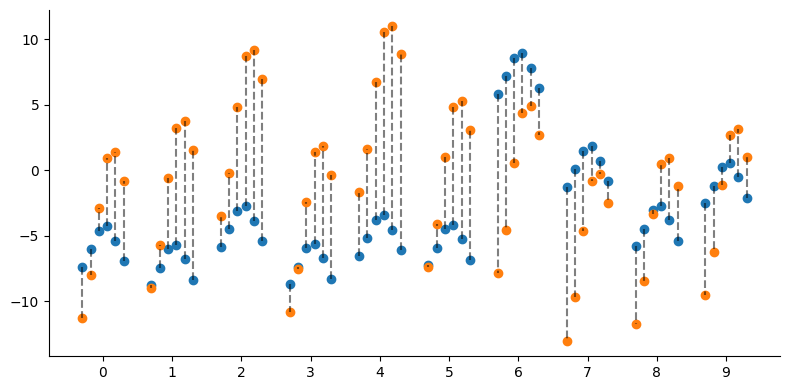

In [303]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4), tight_layout=True)
sns.despine()

for i in range(10):
    step_size = 0.1

    a, b = key_projection_figure(i, distance_metric=dot_product)

    x = np.linspace(0, 0.6, 6) + i
    ax.scatter(x, a, label="Distance Before Key Projection", color="C0")
    ax.scatter(x, b, label="Distance Before Key Projection", color="C1")
    for j in range(6):
        ax.plot([x[j], x[j]], [a[j], b[j]], 'k--', alpha=0.5)

x_ticks = np.arange(0, 10, 1) + 0.3
ax.set_xticks(x_ticks, np.arange(0, 10, 1))
plt.show()

In [41]:
X = dummy_sample[0][1, :].unsqueeze(0)
X_E = embed_proj(transformer2x1, X).squeeze()

In [72]:
((res["Q"] @ X_E.T)).shape

torch.Size([64, 7])

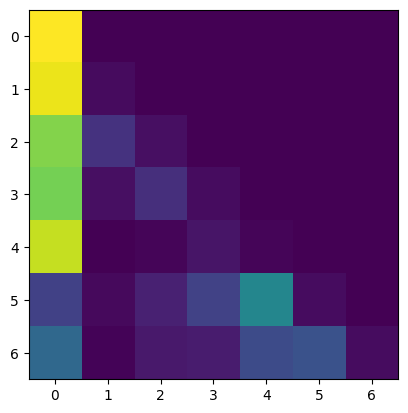

In [75]:
from torch.nn.functional import softmax
d_model = 64
attn_weights = ((res["Q"] @ X_E.T).T @ (res["K"] @ X_E.T))/np.sqrt(d_model)
attn_weights = torch.tril(attn_weights, diagonal=0) + transformer2x1.attn_mask
plt.imshow(attn_weights.detach().numpy(), vmin=0, vmax=1)
plt.imshow(softmax(attn_weights, dim=1).detach().numpy(), vmin=0, vmax=1)

In [604]:
query_task_token = res["Q"] @ X_E[0].reshape(-1, 1)
key_best_token = res["K"] @ X_E[3].reshape(-1, 1)

<BarContainer object of 64 artists>

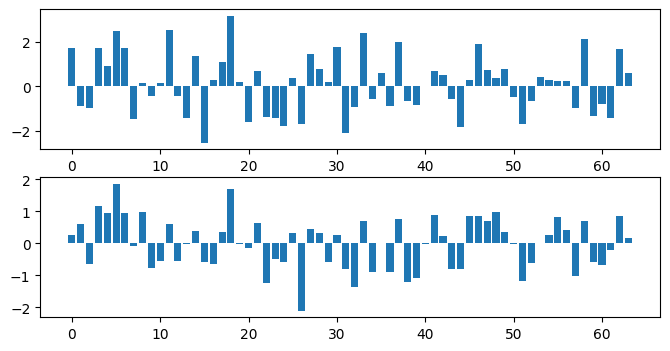

In [615]:
fig, ax = plt.subplots(2, 1, figsize=(8, 4))
ax[0].bar(np.arange(0, 64), query_task_token.detach().numpy().squeeze())
ax[1].bar(np.arange(0, 64), key_best_token.detach().numpy().squeeze())

In [606]:
query_task_token.T @ key_best_token

tensor([[51.8740]], grad_fn=<MmBackward0>)